In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

import tensorflow as tf
from keras.layers import Dense,Input
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [2]:
# # https://www.kaggle.com/crowdflower/twitter-airline-sentiment
# !wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = df[['airline_sentiment','text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


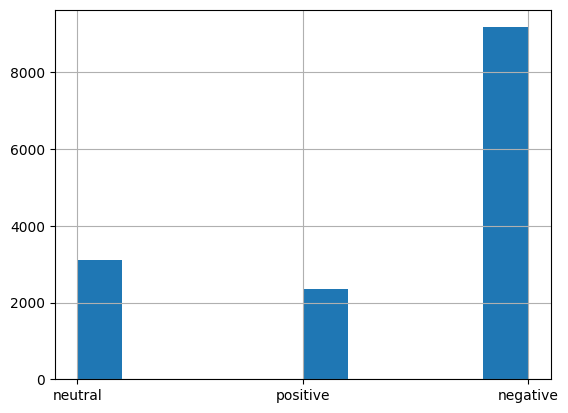

In [6]:
df['airline_sentiment'].hist();

In [7]:
df = df[df['airline_sentiment'] !='neutral'].copy()
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [8]:
target_map = {'positive':1,'negative':0}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [9]:
df_train, df_test = train_test_split(df,random_state=42)

In [10]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [11]:
X_train

<8655x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 131089 stored elements in Compressed Sparse Row format>

In [12]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()


In [13]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
y_train = df_train['target']
y_test = df_test['target']


In [15]:
y_train

8735     1
13018    0
12607    0
1440     0
12181    0
        ..
14349    0
6718     0
7098     1
1149     0
9639     0
Name: target, Length: 8655, dtype: int64

In [16]:
# input dimension
D = X_train.shape[1]

In [17]:
D

2000

In [19]:
# Bulid model
i = Input(shape=(D,))
x = Dense(1)(i)

model = Model(i,x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [21]:
r = model.fit(X_train,y_train, validation_data=(X_test,y_test),
              epochs=40,
              batch_size=128,verbose=2)

Epoch 1/40
68/68 - 2s - loss: 0.4991 - accuracy: 0.7920 - val_loss: 0.3964 - val_accuracy: 0.8049 - 2s/epoch - 27ms/step
Epoch 2/40
68/68 - 0s - loss: 0.3754 - accuracy: 0.7966 - val_loss: 0.3396 - val_accuracy: 0.8205 - 367ms/epoch - 5ms/step
Epoch 3/40
68/68 - 0s - loss: 0.3219 - accuracy: 0.8206 - val_loss: 0.3028 - val_accuracy: 0.8416 - 272ms/epoch - 4ms/step
Epoch 4/40
68/68 - 0s - loss: 0.2845 - accuracy: 0.8454 - val_loss: 0.2769 - val_accuracy: 0.8590 - 290ms/epoch - 4ms/step
Epoch 5/40
68/68 - 0s - loss: 0.2572 - accuracy: 0.8642 - val_loss: 0.2584 - val_accuracy: 0.8749 - 362ms/epoch - 5ms/step
Epoch 6/40
68/68 - 0s - loss: 0.2364 - accuracy: 0.8806 - val_loss: 0.2445 - val_accuracy: 0.8902 - 304ms/epoch - 4ms/step
Epoch 7/40
68/68 - 0s - loss: 0.2199 - accuracy: 0.8942 - val_loss: 0.2337 - val_accuracy: 0.8981 - 361ms/epoch - 5ms/step
Epoch 8/40
68/68 - 0s - loss: 0.2066 - accuracy: 0.9008 - val_loss: 0.2254 - val_accuracy: 0.9058 - 194ms/epoch - 3ms/step
Epoch 9/40
68/68 -

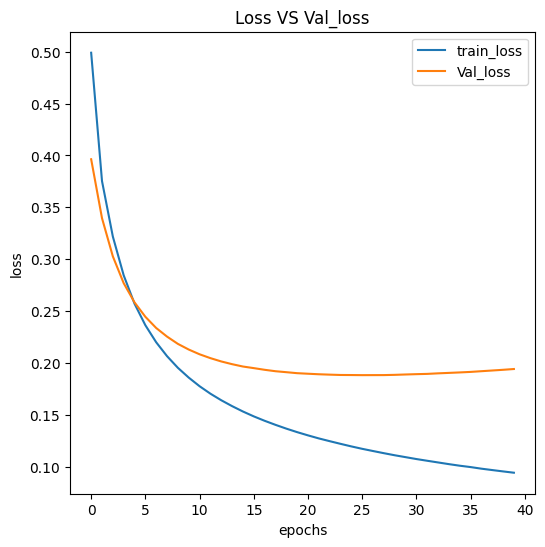

In [26]:
plt.figure(figsize=(6,6))
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='Val_loss')
plt.title('Loss VS Val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


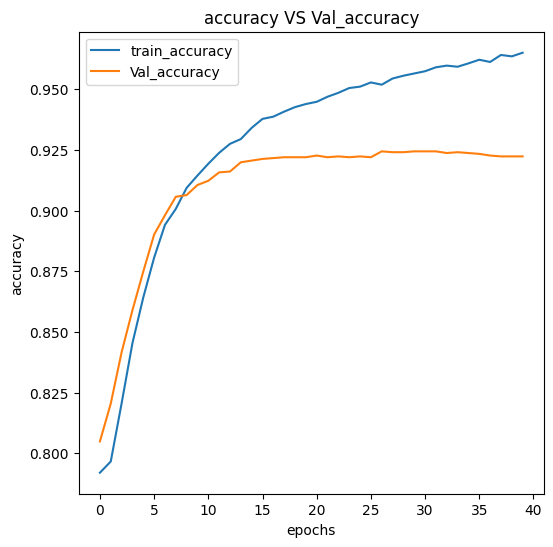

In [27]:
plt.figure(figsize=(6,6))
plt.plot(r.history['accuracy'],label='train_accuracy')
plt.plot(r.history['val_accuracy'],label='Val_accuracy')
plt.title('accuracy VS Val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [28]:
p_train = ((model.predict(X_train) > 0) * 1.0 ).flatten()
p_test = ((model.predict(X_test) > 0) * 1.0 ).flatten()


91/91 [==============================] - 0s 1ms/step


In [29]:
cm = confusion_matrix(y_train, p_train, normalize='true')

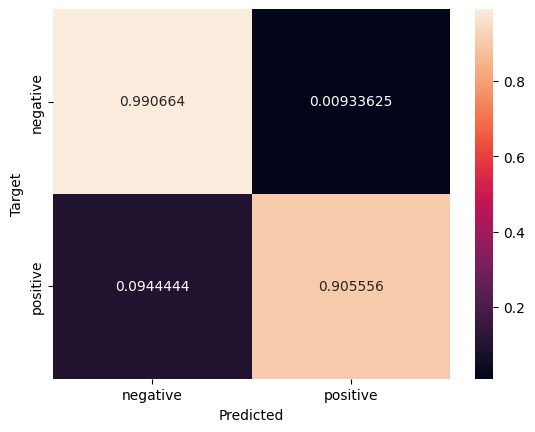

In [30]:
def plot_cm(cm):
  classes = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Target')

plot_cm(cm)

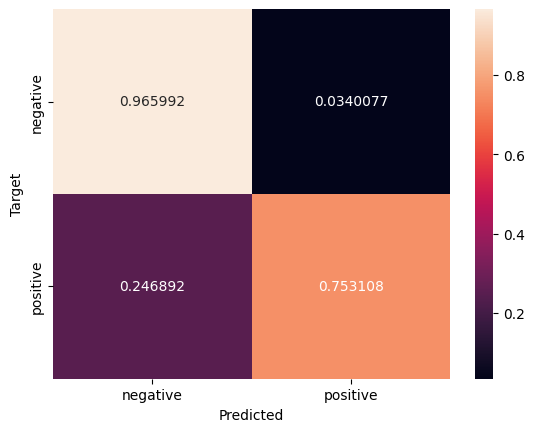

In [31]:
cm_test = confusion_matrix(y_test,p_test,normalize='true')
plot_cm(cm_test)

In [32]:
Pr_train = model.predict(X_train)

271/271 [==============================] - 0s 1ms/step


In [33]:
Pr_test = model.predict(X_test)

91/91 [==============================] - 0s 2ms/step


In [34]:
print('Train AUC:', roc_auc_score(y_train, Pr_train))
print('Test AUC:', roc_auc_score(y_test, Pr_test))

Train AUC: 0.9949850068887268
Test AUC: 0.9546897233549132


In [35]:
print('Train F1:', f1_score(y_train, p_train))
print('Test F1:', f1_score(y_test, p_test))

Train F1: 0.933028048082427
Test F1: 0.7954971857410882


In [36]:
model.layers

In [37]:
model.layers[1].get_weights()

[array([[-3.915838 ],
        [ 3.288384 ],
        [-1.5874329],
        ...,
        [ 2.1348062],
        [ 1.659592 ],
        [-3.028184 ]], dtype=float32),
 array([-0.24316265], dtype=float32)]

In [38]:
w = model.layers[1].get_weights()[0]

In [39]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [41]:
threshold = 2

print('Most positive words:')
word_weight_tuples = []
for word, index in word_index_map.items():
   weight = w[index, 0]
   if weight > threshold:
     word_weight_tuples.append((word,weight))

word_weight_tuples = sorted(word_weight_tuples, key= lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.680406
thanks 9.401409
worries 8.214785
great 7.9442496
awesome 7.4345407
love 7.22509
excellent 7.153835
kudos 6.8953547
amazing 6.4833913
best 6.1629663
